<h1><strong>Generic ARIMA Forecasting Library</strong></h1>
<hr>
<h2><strong>Time Series</strong></h2>
<p>A time series is simply a series of data points ordered in time.</p>
<br>
<h3><strong>Components of time series:</strong></h3>
<ul>
    <li>Trend</li>
    <li>Seasonality</li>
    <li>Irregulaity</li>
    <li>Cyclic</li>
</ul>
<h4><strong>1. Trend</strong></h4>
<p>A movement in graph, relatively higher or lower over a long period of time is called a trend. It consists of uptrend, downtrend and horizontal trend (stationary trend).</p>
<h4><strong>2. Seasonality</strong></h4>
<p>It is a pattern within a fixed time period, usually a year. It is easier to predict if data is seasonal. If the patterns are of fixed calendar based frequencies, then it is seasonal. For eg. Sales of chocolates on Christmas is higher than during other times.</p>
<h4><strong>3. Irregularity</strong></h4>
<p>Irregulaity or noise in data are the spikes. Their nature is erratic and unpredictable.</p>
<h4><strong>4. Cyclic</strong></h4>
<p>It is a data whose period of change (time between two troughs or peaks) is not definite. If the patterns are not of fixed calendar based frequencies, then it is cyclic. For eg. Stocks go through cycles of highs and lows but their time period is not defined and so they’re cyclic. It is much difficult to predict.</p>
<br>
<h3><strong>Type based on no. of variables:</strong></h3>
<ul>
    <li>Univariate</li>
    <li>Multivariate</li>
</ul>
<h4><strong>1. Univariate</strong></h4>
<p>If we only use previous values to predict its future values.</p>
<h4><strong>2. Multivariate</strong></h4>
<p>If we use predictors (like exogenous; X in ARIMAX) other than the series to make a prediction.</p>
<br>

<h3><strong>Stationarity</strong></h3>
<p>A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time.</p>
<br>
<h4><strong>Conditions of stationarity</strong></h4>
<ul>
    <li>Constant mean</li>
    <li>Constant variance</li>
    <li>Constant co-variance - covariance between periods of identical length doesn’t change over time</li>
</ul>
<br>

<h2><strong>Code</strong></h2>
<h3><strong>Importing libraries</strong></h3>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters import bk_filter, hp_filter
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from dateutil.parser import parse
from scipy import signal

<h3><strong>Loading dataset</strong></h3>

In [2]:
input_file_src = '../Datasets/airline-passengers.csv'
variable_name = 'Passengers'

df = pd.read_csv(input_file_src, index_col=0, parse_dates=True)

<h3><strong>Exploring the data</strong></h3>

In [185]:
def explore_series(df, variable_name, window = 12, cutoff = 0.01):
    timeseries = df.copy()
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 12))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.grid(True, linestyle=':')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

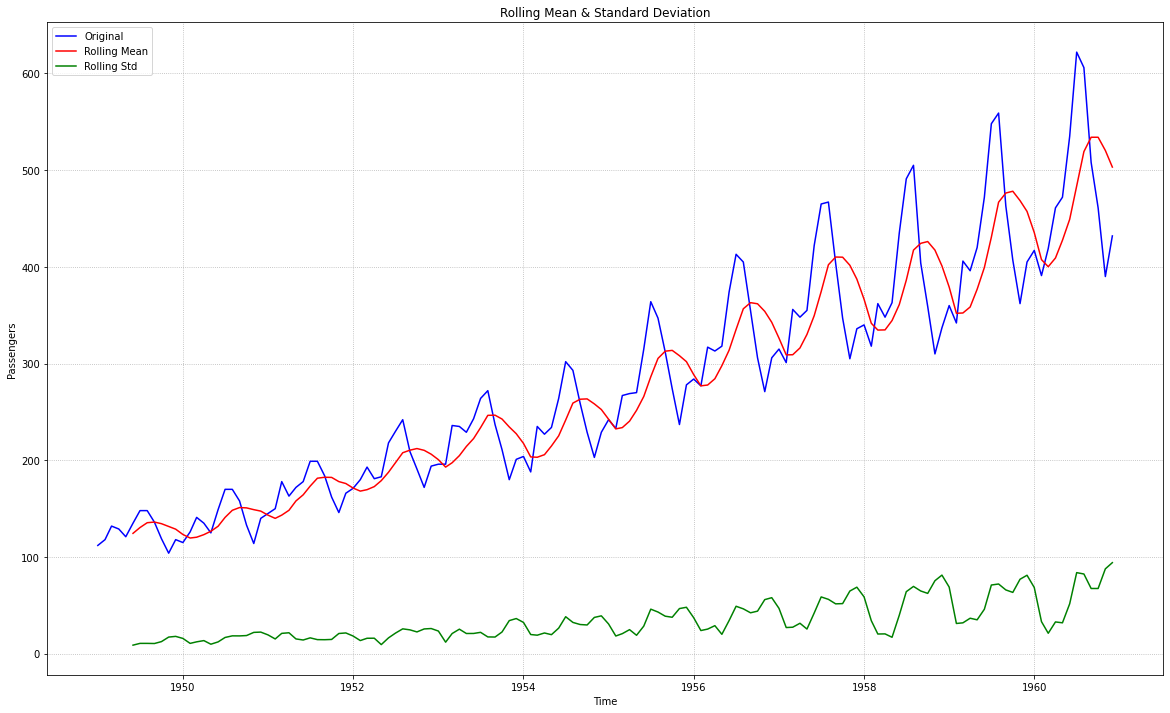

In [186]:
explore_series(df=df, variable_name=variable_name, window=6, cutoff=0.05)

<h3><strong>Visualising seasonality</strong></h3>

In [5]:
def visualize_seasonality(df, variable_name):
    # Prepare data
    s_df = df.copy()
    s_df['year'] = [d.year for d in s_df.index]
    s_df['month'] = [d.strftime('%b') for d in s_df.index]
    years = s_df['year'].unique()
    
    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
    
    # Draw Plot
    plt.figure(figsize=(16,12), dpi= 80)
    for i, y in enumerate(years):
        if i > 0:        
            plt.plot('month', variable_name, data=s_df.loc[s_df.year==y, :], color=mycolors[i], label=y)
            plt.text(s_df.loc[s_df.year==y, :].shape[0]-.9, s_df.loc[s_df.year==y, variable_name][-1:].values[0], y, fontsize=12, color=mycolors[i])
    plt.title("Seasonal Plot of Time Series")
    plt.grid(True, linestyle=':')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.show()

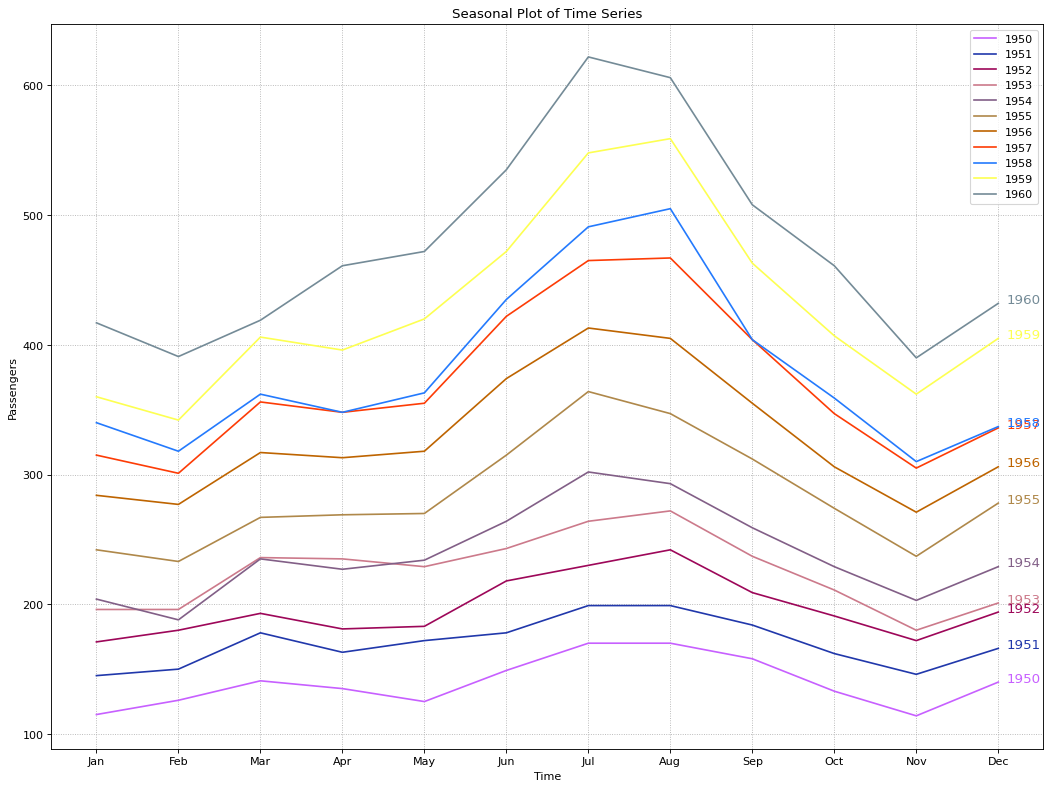

In [6]:
visualize_seasonality(df, 'Passengers')

In [7]:
def year_month_boxplots(df, variable_name):
    # Prepare data
    b_df = df.copy()
    b_df['year'] = [d.year for d in b_df.index]
    b_df['month'] = [d.strftime('%b') for d in b_df.index]
    years = b_df['year'].unique()

    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y=variable_name, data=b_df, ax=axes[0])
    sns.boxplot(x='month', y=variable_name, data=b_df.loc[~b_df.year.isin([1991, 2008]), :])

    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)'); 
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)')
    plt.show()

<h3><strong>Visualising year-month-wise seasonality</strong></h3>

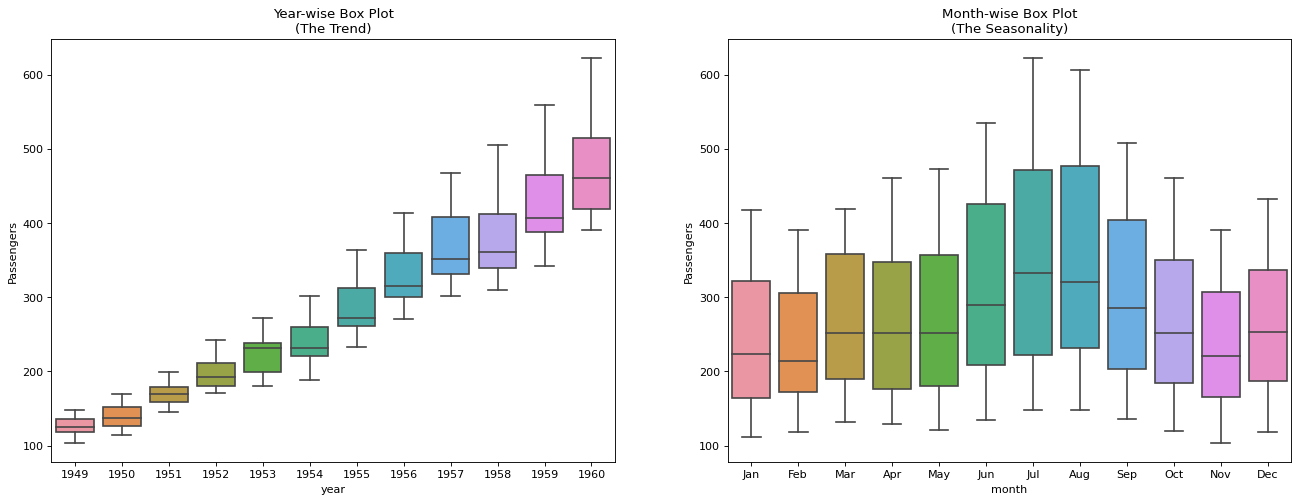

In [8]:
year_month_boxplots(df, 'Passengers')

<h3><strong>Type of time-series based on nature of trend or seasonality</strong></h3>
<ul>
    <li>Additive time series: Value = Base Level + Trend + Seasonality + Error</li>
    <li>Multiplicative Time Series: Value = Base Level x Trend x Seasonality x Error</li>
</ul>
<br>
<h3><strong>Decomposing series into its components</strong></h3>

In [9]:
def series_decompose(df, variable_name):
    
    s_df = df[variable_name].copy()
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(s_df, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(s_df, model='additive', extrapolate_trend='freq')
    
    # Plot
    plt.figure(figsize=(20, 10))
    # additive
    plt.subplot(4,2,1)
    plt.ylabel('Observed')
    plt.title('Additive decomposition')
    result_add.observed.plot()
    
    plt.subplot(4,2,3)
    plt.ylabel('Trend')
    result_add.trend.plot(c='orange')
    
    plt.subplot(4,2,5)
    plt.ylabel('Seasonal')
    result_add.seasonal.plot(c='green')
    
    plt.subplot(4,2,7)
    plt.ylabel('Residual')
    result_add.resid.plot(c='r')
    
    # multiplicative
    plt.subplot(4,2,2)
    plt.ylabel('Observed')
    plt.title('Multiplicative decomposition')
    result_mul.observed.plot()
    
    plt.subplot(4,2,4)
    plt.ylabel('Trend')
    result_mul.trend.plot(c='orange')
    
    plt.subplot(4,2,6)
    plt.ylabel('Seasonal')
    result_mul.seasonal.plot(c='green')
    
    plt.subplot(4,2,8)
    plt.ylabel('Residual')
    result_mul.resid.plot(c='r')
    
    plt.suptitle("Seasonal Decomposition")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

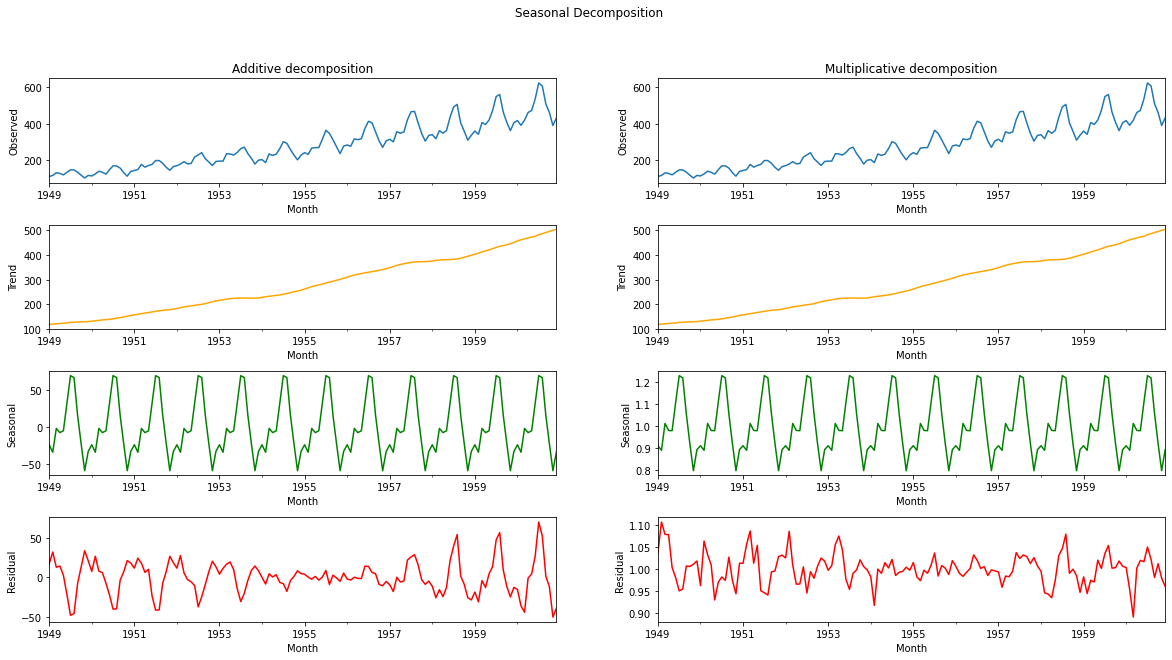

In [10]:
series_decompose(df, variable_name)

<br>
<h3><strong>Why make a series stationary?</strong></h3>
<p>Forecasting a stationary series is relatively easy and the forecasts are more reliable. An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors. We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.</p>

<h3><strong>Testing Stationarity</strong></h3>
<ul>
    <li>Augmented Dickey Fuller test (ADH Test)</li>
    <li>Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)</li>
    <li>Philips Perron test (PP Test)</li>
</ul>
<br>
<h4><strong>ADF</strong></h4>
<p>It's a test where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.</p>

In [11]:
def test_stationarity_adf(df, window = 12, cutoff = 0.01):
    
    timeseries = df.copy()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    print('-'*35)
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('The p-value is %.4f. The series is likely stationary.\n' % pvalue)
    else:
        print('The p-value is %.4f. The series is likely non-stationary.\n' % pvalue)
    print(dfoutput)

<h4><strong>KPSS</strong></h4>
<p>The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.</p>

In [12]:
def test_stationarity_kpss(df, window = 12, cutoff = 0.05):
    
    timeseries = df.copy()
    #Perform Dickey-Fuller test:
    print('Results of Kwiatkowski-Phillips-Schmidt-Shin Test:')
    print('-'*35)
    dftest = kpss(timeseries, regression='c', nlags = 20 )
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in dftest[3].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('The p-value is %.4f. The series is likely non-stationary.\n' % pvalue)
    else:
        print('The p-value is %.4f. The series is likely stationary.\n' % pvalue)
    print(dfoutput)

In [13]:
test_stationarity_adf(df)

Results of Dickey-Fuller Test:
-----------------------------------
The p-value is 0.9919. The series is likely non-stationary.

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity_kpss(df)

Results of Kwiatkowski-Phillips-Schmidt-Shin Test:
-----------------------------------
The p-value is 0.0100. The series is likely non-stationary.

Test Statistic            0.791252
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/prakulsharma/.virtualenvs/arima/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


<h3><strong>Making Stationary</strong></h3>

In [15]:
def make_series_stationary(df, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    
    data = df.copy()
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': data
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        result = adfuller(data.diff(i).dropna())
        # Append P-value
        p_values.append((i, result[1]))
        
    # Keep only those where P-value is lower than significance level
    significant = [p for p in p_values if p[1] < alpha]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = data.diff(diff_order).dropna()
    
    return stationary_series

In [16]:
stationary_df = make_series_stationary(df)

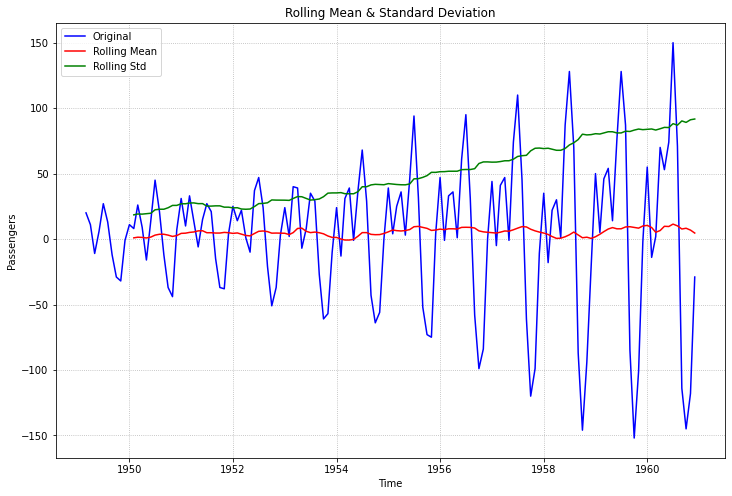

In [17]:
explore_series(stationary_df, variable_name)

<br>
<h3><strong>Detrending a series</strong></h3>
<ul>
    <li>Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.</li>
    <li>Subtract the trend component obtained from time series decomposition</li>
    <li>Subtract the mean</li>
    <li>Apply Baxter-King filter</li>
    <li>Apply Hodrick-Prescott Filter</li>
</ul>

In [96]:
def detrend_series(df, variable_name, function):
    """
    function value:
    1 - line of best fit
    2 - trend component of the decomposition
    3 - mean
    4 - BK filter
    5 - HP filter
    """
    
    if function==1:
        detrended = signal.detrend(df[variable_name].values)
    elif function==2:
        result_mul = seasonal_decompose(df[variable_name], model='multiplicative', extrapolate_trend='freq')
        detrended = df[variable_name].values - result_mul.trend
    elif function==3:
        detrended = df[variable_name].values - df[variable_name].rolling(6).mean()
    elif function==4:
        detrended = bk_filter.bkfilter(df[variable_name], 2, 32, 12)
    elif function==6:
        cycle, trend = hp_filter.hpfilter(df[variable_name])
        detrended = df[variable_name].values - trend
    else:
        detrended = signal.detrend(df[variable_name].values)
    
    plt.figure(figsize=(12, 8))
    plt.plot(detrended)
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.title('Detrended series')
    plt.show()

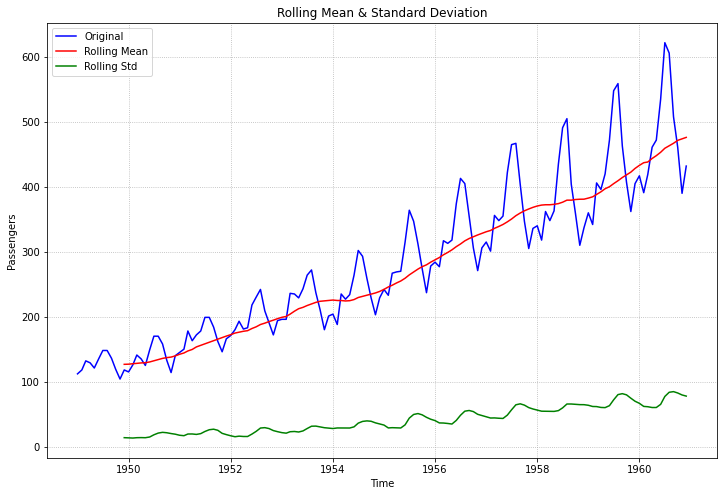

In [102]:
explore_series(df, variable_name)

<h4><strong>1. subtract line of best fit</strong></h4>

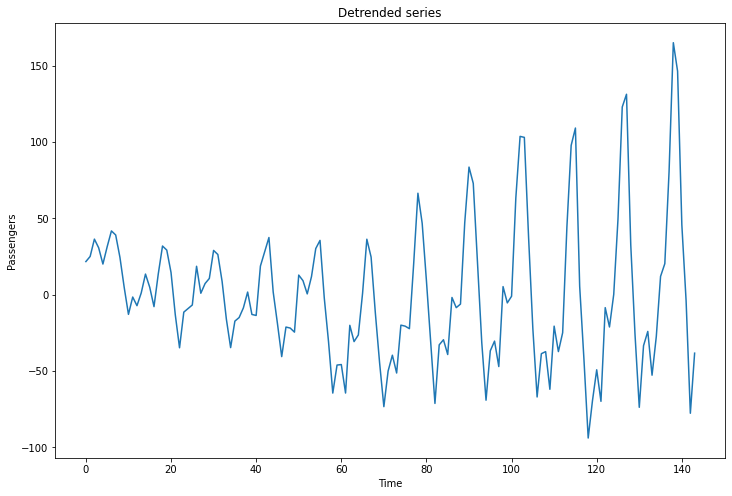

In [61]:
detrend_series(df, variable_name, 1)

<h4><strong>2. subtract the trend component from decomposition</strong></h4>

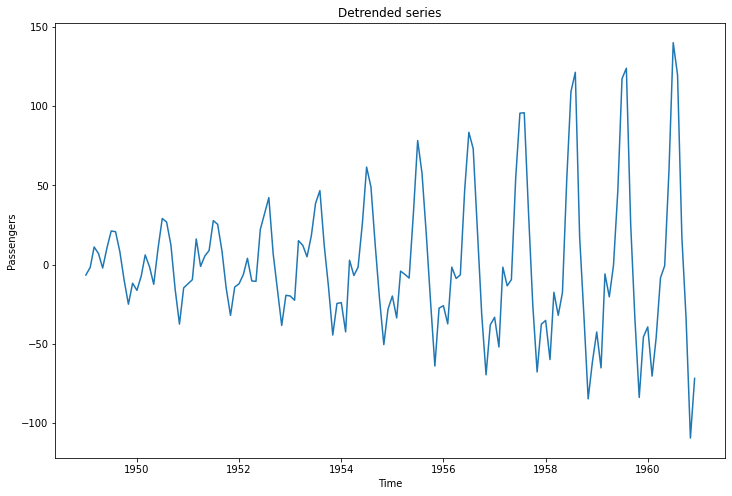

In [62]:
detrend_series(df, variable_name, 2)

<h4><strong>3. subtract the mean</strong></h4>

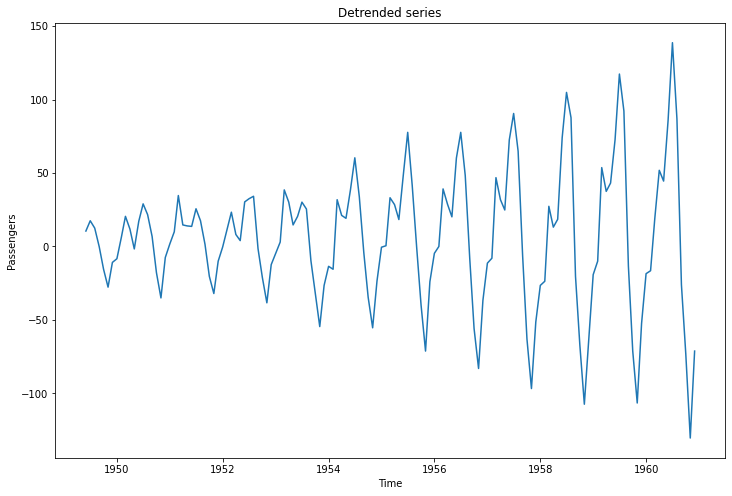

In [87]:
detrend_series(df, variable_name, 3)

<h4><strong>4. BK Filter</strong></h4>

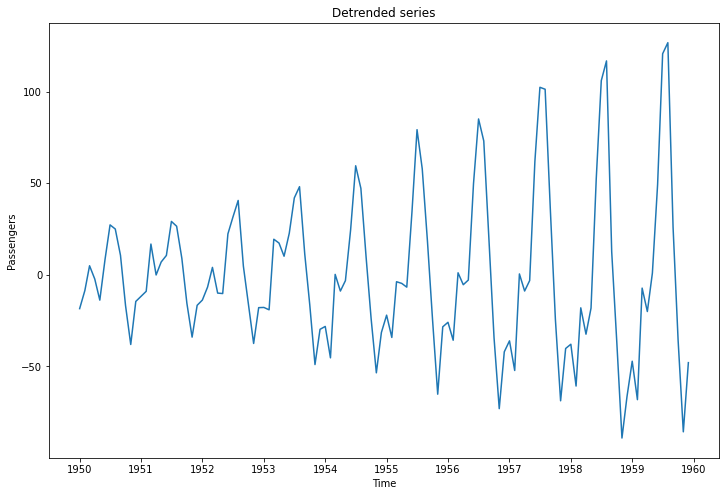

In [97]:
detrend_series(df, variable_name, 4)

<h4><strong>5. HP Filter</strong></h4>

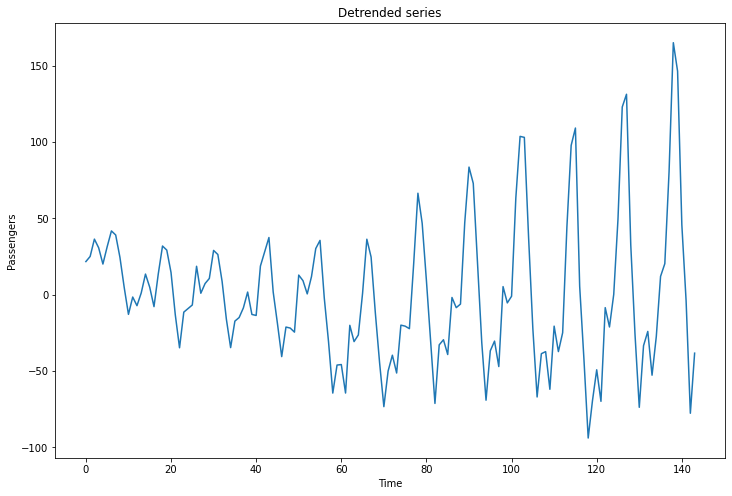

In [67]:
detrend_series(df, variable_name, 5)

<br>
<h3><strong>Deseasonalise a series</strong></h3>
<ul>
    <li>Take a moving average with length as the seasonal window.</li>
    <li>Seasonal difference the series (subtract the value of previous season from the current value)</li>
    <li>Divide the series by the seasonal index obtained from STL decomposition</li>
</ul>

In [166]:
def deseasonalise_series(df, variable_name, function_name, season_size):
    """
    funtion_name value:
    1 - rolling mean with window size = season
    2 - seasonal difference
    3 - seasonal index from decomposition
    """
    dataset = df.copy()
    if function_name==1:
        deseasonalised = dataset.rolling(season_size).mean()
    elif function_name==2:
        for i in range(len(dataset) - interval):
            dataset[variable_name][i+interval] = dataset[variable_name][i+interval] - dataset[variable_name][i]
        deseasonalised = dataset
    else:
        result_mul = seasonal_decompose(dataset[variable_name], model='multiplicative', extrapolate_trend='freq')
        deseasonalised = dataset[variable_name] / result_mul.seasonal
    
    plt.figure(figsize=(12, 8))
    plt.plot(deseasonalised)
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.title('Deseasonalised series')
    plt.show()

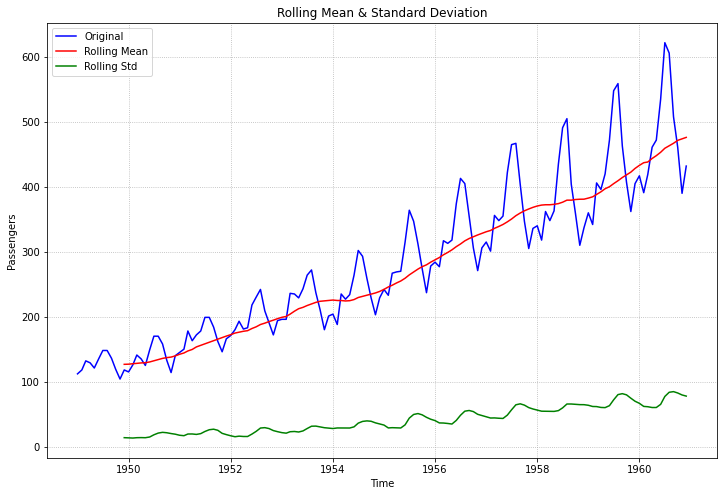

In [171]:
explore_series(df, variable_name)

<h4><strong>1. Taking moving average</strong></h4>

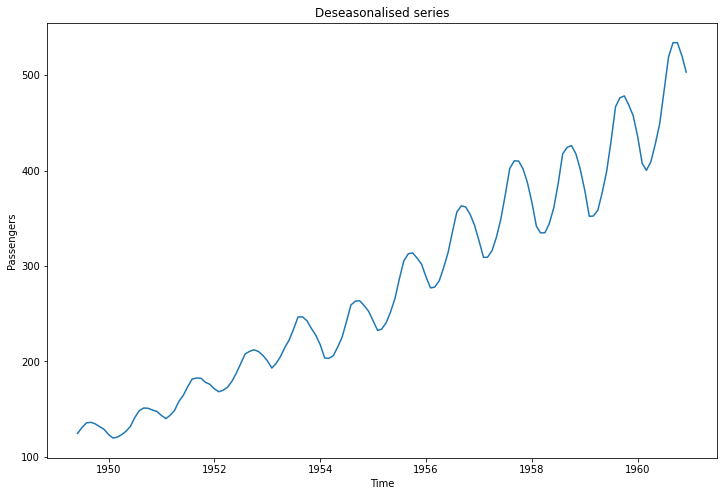

In [172]:
deseasonalise_series(df, variable_name, 1, 6)

<h4><strong>2. Seasonal difference</strong></h4>

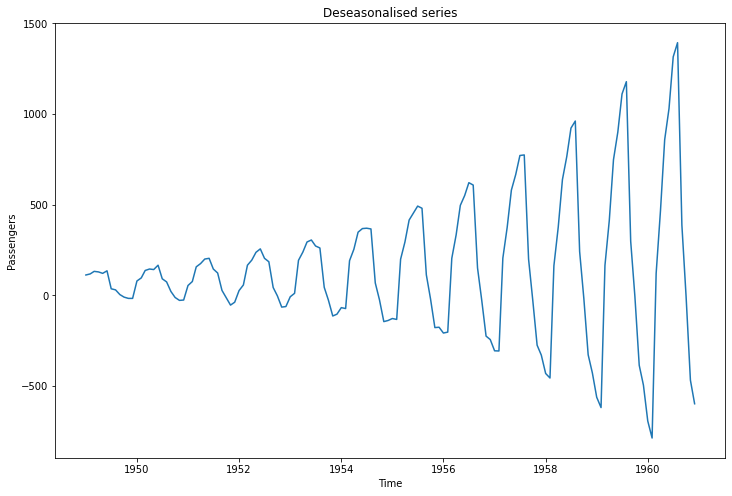

In [173]:
deseasonalise_series(df, variable_name, 2, 6)

<h4><strong>3. Seasonal index</strong></h4>

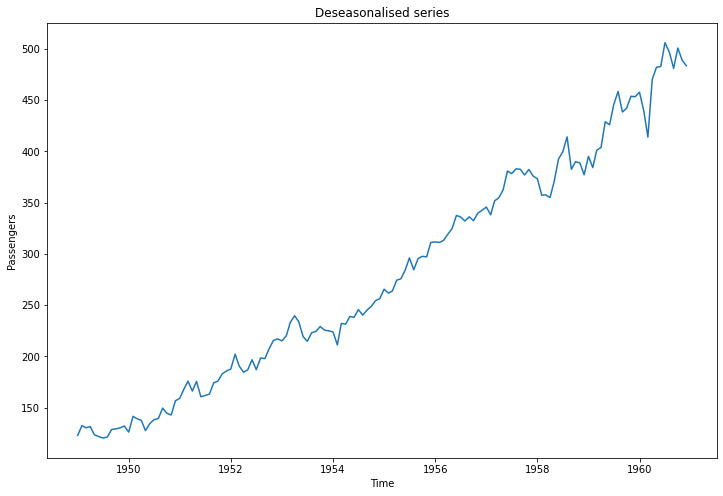

In [174]:
deseasonalise_series(df, variable_name, 3, 6)